Есть данные с бразильского маркетплейса. Они лежат в ClickHouse на удаленном сервере. Чтобы получить к ним доступ, необходимо заменить переменные `user` и `password` на те, что передал HR, и передать запрос строкой в функцию ниже. 

Таблицы:
* vk.orders
* vk.products
* vk.customers

Для получения описания столбцов можно использовать [DESCRIBE TABLE](https://clickhouse.tech/docs/ru/sql-reference/statements/misc/#misc-describe-table)
ClickHouse – колоночная база данных для хранения широких денормализованных таблиц. Поскольку у нас в день пишется в таблицу легко пишется >10кк строк, с ними необходимо работать максимально аккуратно. Поэтому введем следующие ограничения:
* Никаких SELECT *
* Максимально агрегировать данные в самом ClickHouse

Полезный референс по функциям [тут](https://clickhouse.tech/docs/ru/sql-reference/aggregate-functions/reference/).

Необходимо провести анализ покупок. Можно использовать любые данные и любые разрезы. Задание творческое, поэтому лучше всего ограничить себя по времени, чтобы не слишком зарываться.
Оформить в виде *.ipynb максимально просто, чтобы любой менеджер мог его понять.

In [ ]:

user = 'jolly_hawking'
password = 'q6RuVGAk8nVEe09q'

import requests
import pandas as pd
import numpy as np
from io import StringIO
from requests.auth import HTTPBasicAuth

import matplotlib.pyplot as plt
import seaborn as sns

def get_df(query: str, user: str = user, password: str = password) -> pd.DataFrame:
    ''''''
    resp = requests.post(
        'https://clickhouse.kkmagician.com/', 
        data=(query + " FORMAT TSVWithNames").encode('utf-8'), 
        auth=HTTPBasicAuth(user, password)
    )

    if resp.status_code == 200:
        df = pd.read_csv(StringIO(resp.text), sep='\t')
        return df
    else:
        raise ValueError(resp.text)

## Описание таблиц

In [ ]:
products = get_df('describe vk.products')

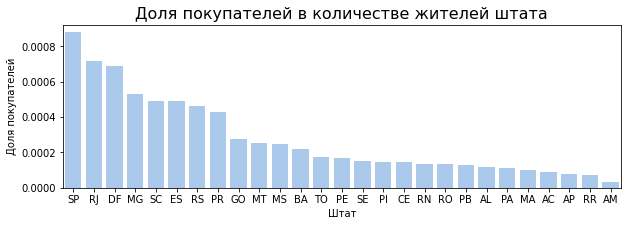

In [ ]:
#@title
# Выборка покупателей по штатам
customer_state = get_df("""

SELECT
    customer_state,
    count(DISTINCT customer_id) as customers
FROM vk.customers
GROUP BY customer_state
Order by customers DESC
LIMIT 100

""")
customer_state.head()

# Загрузка данных о населении штатов Бразилии
states_path = 'https://raw.githubusercontent.com/At7sharp/projects/7bbe0a9ed9e13472932236f00fd92d69aa3b04d5/states.csv'
states_pop = pd.read_csv(states_path, sep=',')
state_rate = pd.merge(customer_state, states_pop, how='left', left_on='customer_state', right_on='UF')
state_rate = state_rate[['customer_state', 'customers', 'Population']]
state_rate['state_coverage'] = state_rate.customers / state_rate.Population
state_rate.sort_values(by='state_coverage', ascending=False, ignore_index=True, inplace=True)

plt.figure(figsize=(10,3))
sns.set_color_codes("pastel")
plot_0 = sns.barplot(x=state_rate.customer_state, y=state_rate.state_coverage, color='b')
plot_0.set_title ('Доля покупателей в количестве жителей штата', fontsize=16)
plot_0.set_xlabel('Штат')
plot_0.set_ylabel('Доля покупателей')
print('')

# Диагностика данных

In [ ]:
#@title
print('Количество записей о покупателях / количество уникальных:')
display(
    get_df("""
            SELECT
              count(customer_id) AS customers,
              count(DISTINCT customer_id) AS uniq_customers
            FROM vk.customers
            LIMIT 100
    """))
print('')
print('')

print('Ассортимент товаров:')
display(
    get_df("""
            SELECT
              count (distinct product_id) AS total_products,
              count (distinct product_category_name) AS total_categories
            FROM vk.products
            LIMIT 100
    """))
print('')
print('')

print('Количество заказов:')
display(
    get_df("""
            SELECT 
              count(DISTINCT order_id) AS orders
            FROM vk.orders
            LIMIT 100
    """))
print('')
print('')

print('Временной интервал заказов для анализа:')
display(
    get_df("""
            SELECT 
              min(order_purchase_timestamp) AS start_of_period,
              max(order_purchase_timestamp) AS end_of_period
            FROM vk.orders
    """))
print('')

Количество записей о покупателях / количество уникальных:


,customers,uniq_customers
0,96096,96096




Ассортимент товаров:


,total_products,total_categories
0,32328,71




Количество заказов:


,orders
0,98666




Временной интервал заказов для анализа:


,start_of_period,end_of_period
0,2016-09-04 21:15:19,2018-09-03 09:06:57


# Как пользователи делают заказы

,orders_num,customers_num,part
4,1,90557,0.942360
2,2,2573,0.026775
1,3,181,0.001884
0,4,28,0.000291
3,5,9,0.000094
5,6,5,0.000052
6,7,3,0.000031
7,9,1,0.000010
8,15,1,0.000010


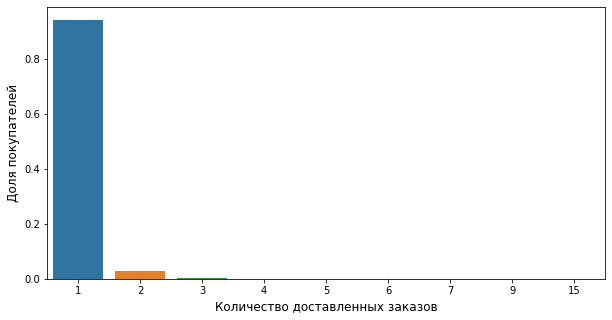

In [ ]:
# @title  Распределение числа пользователей по количествую заказов
orders_by_customer = get_df("""

SELECT
    orders_num,
    count(customer_id) AS customers_num

FROM (
    
    SELECT
        customer_id,
        count(DISTINCT order_id) AS orders_num
    FROM vk.orders
    WHERE order_status = 'delivered'
    GROUP BY customer_id
)

GROUP BY orders_num

""")

total_customers = 96096
orders_by_customer['part'] = orders_by_customer.customers_num / total_customers
display(orders_by_customer.sort_values('customers_num', ascending=False))

plt.figure(figsize=(10,5))
plot = sns.barplot(data=orders_by_customer, y='part', x='orders_num')
plot.set_ylabel("Доля покупателей", fontsize=12)
plot.set_xlabel("Количество доставленных заказов", fontsize=12);

Видим, что основная часть клиентов сделала только один заказ.

,orders,uniq_products_sum
7,93281,1
6,2808,2
5,298,3
4,69,4
2,10,6
3,8,5
1,3,7
0,1,8


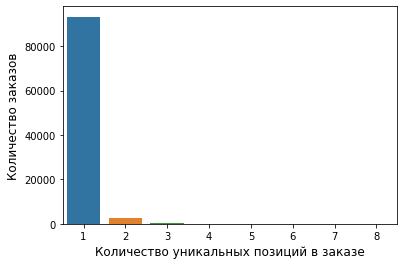

In [ ]:
#@title Ассортимент в заказах
products_in_cart = get_df("""
SELECT
    count(order_id) AS orders,
    uniq_products_sum
FROM (
    SELECT
        order_id,
        count(DISTINCT product_id) AS uniq_products_sum
    FROM vk.orders
    WHERE order_status = 'delivered'
    GROUP BY order_id
    ORDER BY uniq_products_sum DESC
    )
GROUP BY uniq_products_sum
ORDER BY uniq_products_sum DESC
""")

display(products_in_cart.sort_values('orders', ascending=False))

plot_2 = sns.barplot(data=products_in_cart, x='uniq_products_sum', y='orders')
plot_2.set_ylabel("Количество заказов", fontsize=12)
plot_2.set_xlabel("Количество уникальных позиций в заказе", fontsize=12);

Text(0.5, 0, 'Количество проданных товаров')

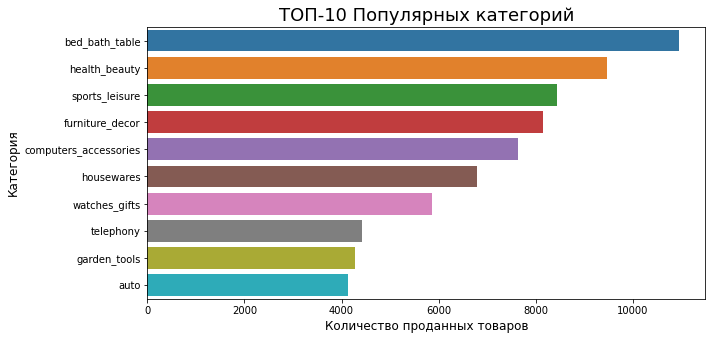

In [ ]:
#@title Популярность категорий продуктов

category_total = get_df("""

SELECT 
    product_category_name AS category,
    sum(products_num) AS category_quantity
    
FROM
    (SELECT
        product_id,
        count(order_id) AS products_num
    FROM vk.orders
    WHERE order_status = 'delivered'
    GROUP BY product_id
    ORDER BY products_num DESC) AS l
    
JOIN
    vk.products as r
    
ON l.product_id=r.product_id

GROUP BY category
ORDER BY category_quantity DESC
LIMIT 10
""")


plt.figure(figsize=(10,5))
plot_2 = sns.barplot(data=category_total, x='category_quantity', y='category')
plot_2.set_title('ТОП-10 Популярных категорий', fontsize=18)
plot_2.set_ylabel("Категория", fontsize=12)
plot_2.set_xlabel("Количество проданных товаров", fontsize=12)

In [ ]:
#@title
checks = get_df("""
SELECT
    order_id,
    sum(price) AS check_sum
FROM vk.orders
WHERE order_status = 'delivered'
GROUP BY order_id
""")

# Посмотрим на сумму чеков:

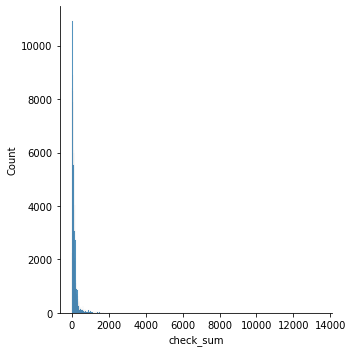

In [ ]:
#@title
check_1 = sns.displot(checks.check_sum, bins=1000)

Укрупним интересующий диапазон и оценим с помощью боксплота распределние стоимости заказов

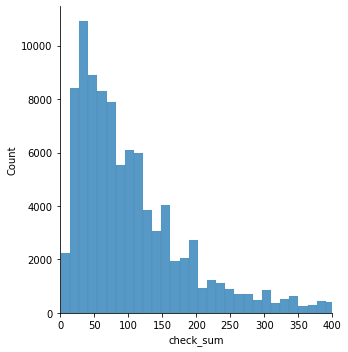

In [ ]:
#@title
sns.displot(checks.check_sum, bins=1000).set(xlim=(-1, 400))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Сумма чека')

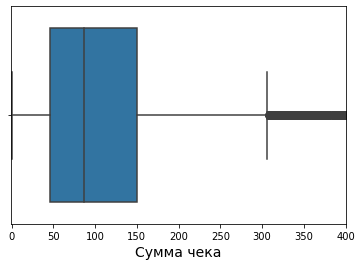

In [ ]:
#@title
check_plot = sns.boxplot(checks.check_sum)
check_plot.set(xlim=(-1, 400))
check_plot.set_xlabel("Сумма чека", fontsize=14)

## Практически все наблюдения укладываются между 0 и 300 бразильскими рублями, однако выбросов тоже немало и нужно бы оценить какую долю выручки приносят крупные чеки.

In [ ]:
#@title Суммарная выручка за период

RV = get_df(""" SELECT
                sum(price) AS rv
    FROM vk.orders
    WHERE order_status = 'delivered'
    """)

RV
total_RV = RV.iloc[0]['rv']
total_RV

13221498.112056853

In [ ]:
#@title Выручка за период в категории чеков до 300 рублей

RV_under_300 = get_df(""" SELECT 
    sum(check_sum) AS rv
FROM
    (SELECT
        order_id,
        sum(price) AS check_sum
    FROM vk.orders
    WHERE order_status = 'delivered'
    GROUP BY order_id)
WHERE check_sum < 300
    """)

RV_small_checks= RV_under_300.iloc[0]['rv']
RV_small_checks


8356033.535678983

In [ ]:
#@title Выручка за период в категории чеков более 300 рублей

RV_above_300 = get_df(""" SELECT 
    sum(check_sum) AS rv
FROM
    (SELECT
        order_id,
        sum(price) AS check_sum
    FROM vk.orders
    WHERE order_status = 'delivered'
    GROUP BY order_id)
WHERE check_sum > 300
    """)

RV_big_cheсks= RV_above_300.iloc[0]['rv']
RV_big_cheсks


4854364.576377869

In [ ]:
#@title
print('Выручка по чекам менее 300 руб - ', round(RV_small_checks/total_RV *100, 2), '%')
print('Выручка по чекам более 300 руб - ', round(RV_big_cheсks/total_RV *100, 2), '%')

Выручка по чекам менее 300 руб -  63.2 %
Выручка по чекам более 300 руб -  36.72 %


Несмотря, на низкое количество дорогих покупок, этот "длинных хвост" приносит существенный вклад в Revenue.

Посмотрим на динамику заказов во времени

In [ ]:
orders_by_date = get_df("""
SELECT 
    count(distinct order_id) AS orders_count,
    toStartOfDay(order_purchase_timestamp) AS date
FROM vk.orders
WHERE order_status = 'delivered'
GROUP BY date
""")

orders_by_date.date = pd.to_datetime(orders_by_date.date)
orders_by_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   orders_count  612 non-null    int64         
 1   date          612 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.7 KB


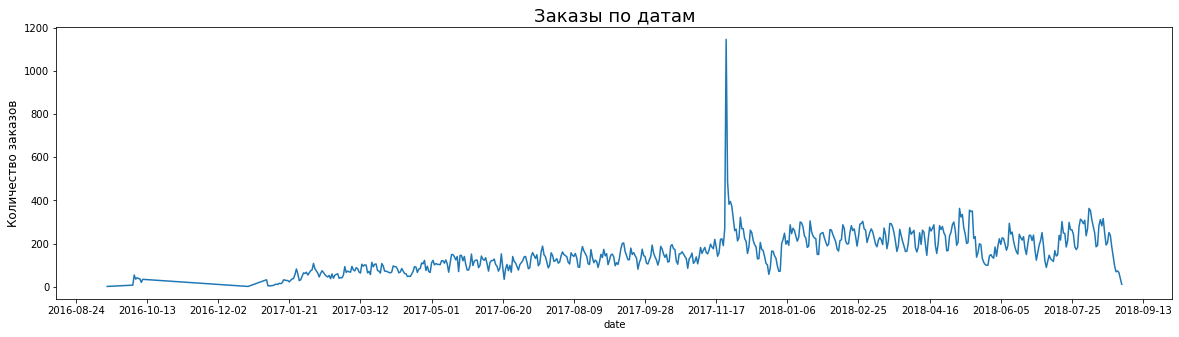

In [ ]:
plt.figure(figsize=(20, 5))
import matplotlib.ticker as ticker
dateline = sns.lineplot(data=orders_by_date, x='date', y='orders_count')

dateline.set_title('Заказы по датам', fontsize=18)
dateline.set_ylabel("Количество заказов", fontsize=12)
dateline.xaxis.set_major_locator(ticker.MultipleLocator(50))

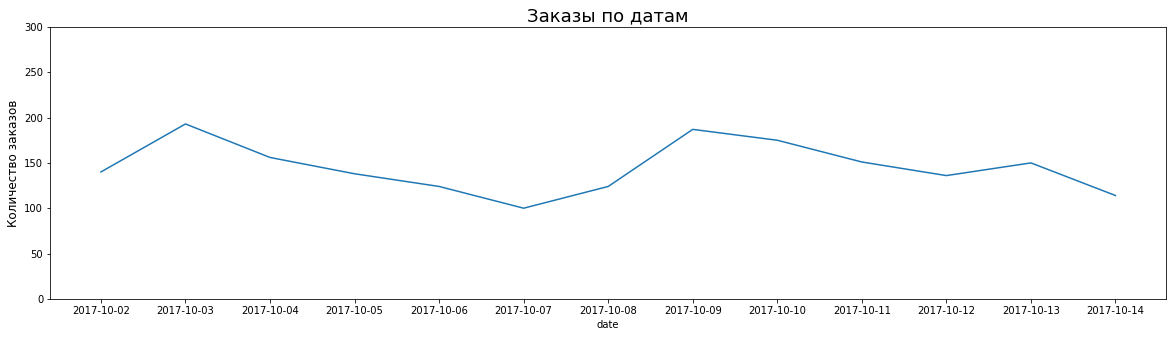

In [ ]:
plt.figure(figsize=(20, 5))
import matplotlib.ticker as ticker
datequery = orders_by_date.query('(date > "2017-10-01") and (date < "2017-10-15")')
dateline = sns.lineplot(data=datequery,
                        x='date',
                        y='orders_count')\
               
dateline.set(ylim=(0, 300))
dateline.set_title('Заказы по датам', fontsize=18)
dateline.set_ylabel("Количество заказов", fontsize=12)
dateline.xaxis.set_major_locator(ticker.MultipleLocator(1))

2017-11-24 Аномальный скачок по выполненым заказам. Вероятно, как реузльтат рекламной кампании или маркетинговой акции.

In [ ]:
get_df("""
    describe vk.orders
    """)

,name,type,default_type,default_expression,comment,codec_expression,ttl_expression
0,order_id,UInt64,NaN,NaN,NaN,NaN,NaN
1,order_status,LowCardinality(String),NaN,NaN,"Последний статус заказа (т.к. это история, бол...",NaN,NaN
2,order_purchase_timestamp,DateTime,NaN,NaN,"Время, когда пользователь совершил заказ",NaN,NaN
3,order_approved_at,DateTime,NaN,NaN,"Время, когда магазин подтвердил заказ",NaN,NaN
4,order_delivered_carrier_date,DateTime,NaN,NaN,"Время, когда заказ был доставлен службой доставки",NaN,NaN
5,order_delivered_customer_date,DateTime,NaN,NaN,"Время, когда доставка была подтверждена пользо...",NaN,NaN
6,order_estimated_delivery_date,DateTime,NaN,NaN,Оценка даты доставки заказа на момент его сове...,NaN,NaN
7,customer_id,UInt64,NaN,NaN,NaN,NaN,NaN
8,order_item_id,UInt16,NaN,NaN,Порядковый номер товара в заказе,NaN,NaN
9,product_id,UInt64,NaN,NaN,NaN,NaN,NaN


In [ ]:
get_df(
    """
      SELECT 
        sum(price),
        avg(price)
      FROM vk.orders
      
    """)

,sum(price),avg(price)
0,1.359164e+07,120.653739


In [ ]:
get_df(
    """
      SELECT 
        sum(price)*10,
        avg(price)
      FROM vk.orders
      sample 1/10
    """)

,"multiply(sum(price), 10)",avg(price)
0,1.379902e+07,121.931743


In [ ]:
get_df(
    """
      SELECT 
        sum(price),
        avg(price)
      FROM vk.orders
      WHERE (cityHash64(price) % 10 = 0)
    """)

,sum(price),avg(price)
0,1.416018e+06,119.737676
